In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from data_utils import CustomTransform
import numpy as np
import wandb
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import tqdm
import faiss
import pickle

%load_ext autoreload
%autoreload 2
wandb.login(key='14a56ed86de5bf43e377d95d05458ca8f15f5017')

config = {
    'IMG_WIDTH': 256,
    'IMG_HEIGHT': 256,
    'TRAINING_DATASET_DIR': '../Week 1/data/MIT_split/train',
    'TEST_DATASET_DIR': '../Week 1/data/MIT_split/test',
    'batch_size': 32,
    'classifier': 'knn',
    'n_neighbors': 50,
    'metric': 'euclidean',
    'voronoi_cells': 8,
    'lookup_cells': 16,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

torch.manual_seed(123) # seed for reproductibility

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: luisgogu2001 (c5-g8). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Luis/.netrc


In [2]:
transform_train = CustomTransform(config, mode='train')
transform_test = CustomTransform(config, mode='test')

train_dataset = datasets.ImageFolder(root=config['TRAINING_DATASET_DIR'], transform=transform_train)
test_dataset = datasets.ImageFolder(root=config['TEST_DATASET_DIR'], transform=transform_test)

total_length = len(train_dataset)
train_size = int(0.8 * total_length)  # e.g., 80% for training
valid_size = total_length - train_size  # remaining 20% for validation

# Split dataset
train_dataset, validation_dataset = random_split(train_dataset, [train_size, valid_size])

dataloader_train = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
dataloader_validation = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [3]:
# Model Definition remains the same
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.DEFAULT')
        self.model.fc = nn.Identity()
        
    def forward(self, x):
        return self.model(x)

model = Net()
# model.load_state_dict(torch.load('pretrained/best_model_siamese.pth', map_location=config['device']))
model = model.to(config['device'])

Using cache found in C:\Users\Luis/.cache\torch\hub\pytorch_vision_v0.10.0


In [4]:
# Define a function to extract features from an image
def extract_features(loader, model, device):
    model.eval()
    with torch.no_grad():    
        features, labels = [], []
        for img, label in tqdm.tqdm(loader, total=len(loader), desc='Extracting features'):
            features.append(model(img.to(device)).cpu().detach().numpy())
            labels.append(label)
    return np.concatenate(features).astype('float32'), np.concatenate(labels)


# k-NN Classifier for Image Retrieval
class ImageRetrievalSystem:
    def __init__(self, model, train_dataloader, test_dataloader, config):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.device = config['device']

        self.dim = 2048
        self.classifier_type = config['classifier']
        self.n_neighbors = config['n_neighbors']

        if self.classifier_type == 'knn':
            self.classifier = NearestNeighbors(n_neighbors=config['n_neighbors'], metric=config['metric'])
        else:
            self.classifier = faiss.IndexIVFFlat(faiss.IndexFlatL2(self.dim), self.dim, config['voronoi_cells'])
            self.classifier.nprobe = config['lookup_cells']

    def fit(self, precomputed=False):

        if not precomputed:
            features, self.train_labels = extract_features(self.train_dataloader, self.model, self.device)

            with open('train_features.pkl', 'wb') as f:
                pickle.dump((features, self.train_labels), f)

        else:
            with open('train_features.pkl', 'rb') as f:
                features, self.train_labels = pickle.load(f)
        
        print('Fitting the classifier...')
        if self.classifier_type == 'knn':
            self.classifier.fit(features, self.train_labels)
        else:
            self.classifier.train(features)
            self.classifier.add(features)

    def retrieve(self, precomputed=False):

        if not precomputed:
            features, labels = extract_features(self.test_dataloader, self.model, self.device)

            with open('test_features.pkl', 'wb') as f:
                pickle.dump((features, labels), f)
        
        else:
            with open('test_features.pkl', 'rb') as f:
                features, labels = pickle.load(f)
        
        print('Retrieving images...')
        if self.classifier_type == 'knn':
            _, predictions = self.classifier.kneighbors(features, return_distance=True)
        else:
            _, predictions = self.classifier.search(features, self.n_neighbors)
        
        return predictions, labels

In [69]:
def evaluate(predictions, labels):

    # Prec@1
    prec_at_1 = np.mean([1 if predictions[i, 0] == labels[i] else 0 for i in range(predictions.shape[0])])

    # Prec@5
    prec_at_5 = np.mean([np.sum([1 if predictions[i, j] == labels[i] else 0 for j in range(5)]) / 5 for i in range(predictions.shape[0])])

    # Initialize list to store average precision for each query
    average_precisions = []

    # Compute binary relevance arrays and calculate average precision for each query
    for i in range(predictions.shape[0]):
        # Convert true label into binary format for each prediction
        binary_relevance = np.array([1 if label == labels[i] else 0 for label in predictions[i, :5]])
        
        # Ensure there is at least one positive class to avoid division by zero in AP score calculation
        if np.sum(binary_relevance) > 0:
            # Compute the average precision for the current query
            ap_score = average_precision_score(binary_relevance, np.ones_like(binary_relevance))
            average_precisions.append(ap_score)

    # Compute mean Average Precision (mAP) by averaging all the AP scores
    mean_ap = np.mean(average_precisions)

    return prec_at_1, prec_at_5, mean_ap

In [70]:
config['n_neighbors'] = len(train_dataset)
pipeline = ImageRetrievalSystem(model, dataloader_train, dataloader_test, config)
pipeline.fit(precomputed=True)
predictions, labels = pipeline.retrieve(precomputed=True)

predictions = pipeline.train_labels[predictions]

evaluate(predictions, labels)

Fitting the classifier...
Retrieving images...


(0.895910780669145, 0.8783147459727385, 0.8926952141057936)

100%|██████████| 375/375 [00:04<00:00, 80.13it/s]


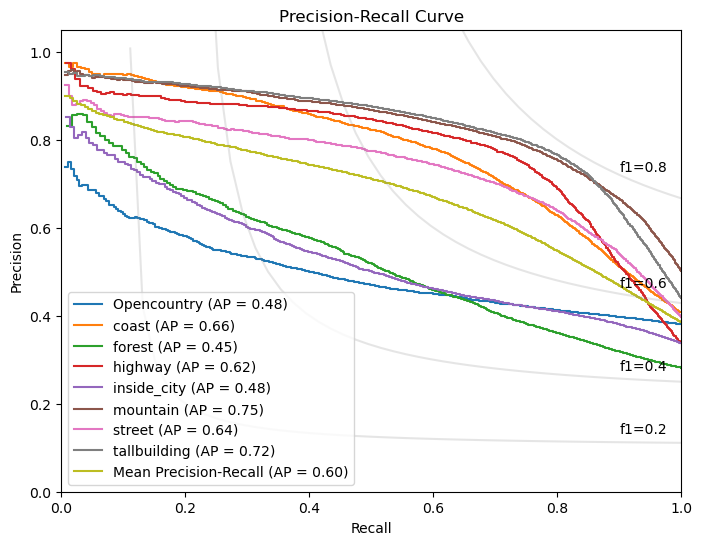

In [65]:
def precision_at_k(predictions, labels, k):
    correct_pred = (predictions[:, :k] == labels[:, None]).sum(axis=1) / k
    return correct_pred.mean()

def binary_recall_at_k(predictions, binary_labels, k):
    recalls = []
    for i in range(predictions.shape[0]):
        correct = np.sum(binary_labels[predictions[i, :k]] == 1)
        total_correct = np.sum(binary_labels == 1) # Total correct for the class across all predictions
        recalls.append(correct / total_correct if total_correct > 0 else 0)
    return np.mean(recalls)

def recall_at_k(predictions, labels, k):
    recalls = []
    for i in range(predictions.shape[0]):
        correct = (predictions[i, :k] == labels[i]).sum()
        total_correct = (predictions[i] == labels[i]).sum()
        recalls.append(correct / total_correct if total_correct > 0 else 0)
    return np.mean(recalls)


unique_classes = np.unique(labels)  # Determine unique classes

# Initialize dictionaries to store precision and recall values for each class at each k
precision_at_k_values = {class_idx: [] for class_idx in unique_classes}
recall_at_k_values = {class_idx: [] for class_idx in unique_classes}

# Loop over k values
for k in tqdm.tqdm(range(1, config['n_neighbors'])):
    # For each class, calculate precision and recall at current k
    for class_idx in unique_classes:
        binary_labels = (labels == class_idx)
        
        precision_at_k_values[class_idx].append(precision_at_k(predictions[binary_labels], labels[binary_labels], k))
        recall_at_k_values[class_idx].append(recall_at_k(predictions[binary_labels], labels[binary_labels], k))

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# For each class, plot the precision-recall curve
for class_idx in unique_classes:
    precision_values = precision_at_k_values[class_idx]
    recall_values = recall_at_k_values[class_idx]
    
    display = PrecisionRecallDisplay(precision=precision_values, recall=recall_values)
    display.plot(name=f'{test_dataset.classes[class_idx]} (AP = {np.mean(precision_values):.2f})', ax=ax)

# plot the mean precision-recall curve
precision_values = np.mean([precision_at_k_values[class_idx] for class_idx in unique_classes], axis=0)
recall_values = np.mean([recall_at_k_values[class_idx] for class_idx in unique_classes], axis=0)
display = PrecisionRecallDisplay(precision=precision_values, recall=recall_values)
display.plot(name='Mean Precision-Recall (AP = {:.2f})'.format(np.mean(precision_values)), ax=ax)

# Add iso F1 curves
f1_scores = np.linspace(0.2, 0.8, num=4)
for f1_score in f1_scores:
    x = np.linspace(0.01, 1)
    y = f1_score * x / (2 * x - f1_score)
    plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate(f'f1={f1_score:0.1f}', xy=(0.9, y[45] + 0.02))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve')
plt.show()
